Стратегия объединяет BBANDS, RSI и определенные свечные паттерны для обнаружения точек разворота и определения оптимальных позиций входа.
- RSI - потдверждение тренда
- ATR - управления торговлей, используется для подсчета параметров стоп-лосса и тейк-профита (класс StopLossStrategy2 [backtest_strategy.ipynb](backtest_strategy.ipynb))
- get_best_bb_rsi_strategy, backest_bb_rsi_strategy, apply_bb_rsi_strategy, add_bb_rsi_signal, walk_forward_optimization ([useful_functions.ipynb](useful_functions.ipynb))


In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# period=-(datetime.now() - (datetime.now() - relativedelta(years = 8))).days
period=-(datetime.now() - datetime(2016, 1, 1)).days
time_interval='1d'
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X']
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']
dir = 'forex_data'


In [ ]:
%run forex_data_loader.ipynb

In [8]:
import pandas as pd
import warnings
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtesting import Backtest
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import import_ipynb

from tqdm import tqdm
tqdm.pandas()
warnings.simplefilter('ignore')

### Usefull functions

In [3]:
# %run file_loader.ipynb
# %run useful_functions.ipynb
# %run backtest_strategy.ipynb

from file_loader import get_data
from useful_functions import get_best_bb_rsi_strategy, walk_forward_optimization_by_index, apply_bb_rsi_ema_strategy, add_pointpos_column, walk_forward_optimization_by_date_range2

from backtest_strategy import StopLossStrategy2

# log.basicConfig(level=log.INFO)

### Walk Forward Optimization
### Calculate Bollinger Bands and RSI,ATR and Signal apply

#### WFO by index

In [4]:
report_dict = {}
symbols =['EURUSD']
for name in symbols:
# for name in forex_tickers:
    df = get_data(dir, name)
    df.reset_index(inplace=True)

    df_length = len(df)
    print(f"Start {name} backtesting, df: {df_length}")
   
    try:
        signals_df = pd.DataFrame()
       
        train_size = 320
        test_size = 180
        index_range = walk_forward_optimization_by_index(len(df), train_size, test_size)
        print(f"{name} wfo iterations: {len(index_range)}")

        params = {
            'bb_period_list': [15, 14, 13], # 13-30
            'bb_width_threshold_list': [0.002, 0.0015, 0.001],
            'atr_period_list': [7, 6, 5], # Long time frames: 20-50, Short: 2-10
            'rsi_period_list': [10, 11, 9], # Short-term intraday: 9-11, Medium-term: 14, Longer-term position: 20-30
            'cash': 10_000,
            # 'maximize': 'Profit Factor',
            'maximize': 'Return [%]',
            # 'maximize': 'Equity Final [$]',
            # 'maximize': 'Win Rate [%]',
            'max_tries': 300, # ???
            # 'stats_item': 'Profit Factor',
            'stats_item': 'Win Rate [%]',
            # 'method': 'skopt',
            'bb_std': 1.5, #1.8, 2
            'back_candles': 7, #8,9
            'ema_period': 30, # 20, 50, based on test_set_size param - ???            
        }

        for iter in tqdm(index_range):
            start_train = iter['train_indexes'][0]
            end_train = iter['train_indexes'][1]
            start_test = iter['test_indexes'][0]
            end_test = iter['test_indexes'][1]
            
            train_set = df.iloc[start_train:end_train].copy()
            test_set = df.iloc[start_test:end_test].copy()

            print(f"{name} : train_set: {train_set.iloc[0].Date} - {train_set.iloc[-1].Date}, test_set: {test_set.iloc[0].Date} - {test_set.iloc[-1].Date}")

            best_params, best_performance = get_best_bb_rsi_strategy(train_set.copy(), StopLossStrategy2, params, apply_bb_rsi_ema_strategy)

            print(f"{name} : best_params: {best_params}, best_performance: {best_performance}")
            if best_performance > 0:
                combined_data = pd.concat([train_set, test_set]).reset_index(drop=True)
                combined_with_test_signal = apply_bb_rsi_ema_strategy(combined_data.copy(), best_params)
                test_with_signal = combined_with_test_signal.iloc[-test_size:].copy()
                signals_df = pd.concat([signals_df, combined_with_test_signal], ignore_index=True)

        if not signals_df.empty:
            report_dict[name] = signals_df
    except Exception as e:
        print(f"Error backtesting for {name}: {e}")

Start EURUSD backtesting, df: 2338
EURUSD wfo iterations: 12


  0%|          | 0/12 [00:00<?, ?it/s]

EURUSD : train_set: 2016-01-01 00:00:00 - 2017-03-23 00:00:00, test_set: 2017-03-24 00:00:00 - 2017-12-04 00:00:00


100%|██████████| 320/320 [00:03<00:00, 93.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: -inf, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.42it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.74it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 107.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:04<00:00, 68.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.94it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 89.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 84.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 87.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 86.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 106.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 86.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.57it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.41it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.96it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 105.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:06<00:00, 50.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 88.41it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 115.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 122.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:04<00:00, 68.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:04<00:00, 75.67it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 88.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 106.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 105.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.31it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:04<00:00, 74.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 83.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 100.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>
EURUSD : best_params: {'cash': 10000, 'maximize': 'Return [%]', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_std': 1.5, 'back_candles': 7, 'ema_period': 30, 'bb_period': 13, 'bb_width_threshold': 0.001, 'atr_period': 5, 'rsi_period': 9}, best_performance: 100.0


  8%|▊         | 1/12 [08:15<1:30:50, 495.54s/it]

EURUSD : train_set: 2016-09-09 00:00:00 - 2017-12-04 00:00:00, test_set: 2017-12-05 00:00:00 - 2018-08-13 00:00:00


100%|██████████| 320/320 [00:03<00:00, 105.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: -inf, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 110.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 105.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 106.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 114.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 108.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 107.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.74it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 105.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 109.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:04<00:00, 78.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.02it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.18it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 108.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 104.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 89.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 88.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 92.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 86.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 90.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 89.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 50.0, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 94.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.47it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 99.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 91.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 96.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 100.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 93.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.86it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 97.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 101.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 103.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:02<00:00, 108.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.59it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 95.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 98.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>


100%|██████████| 320/320 [00:03<00:00, 102.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 57.14285714285714, best_performance: 57.14285714285714, strategy_class: <class 'backtest_strategy.StopLossStrategy2'>
EURUSD : best_params: {'cash': 10000, 'maximize': 'Return [%]', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_std': 1.5, 'back_candles': 7, 'ema_period': 30, 'bb_period': 13, 'bb_width_threshold': 0.001, 'atr_period': 5, 'rsi_period': 9}, best_performance: 57.14285714285714


 17%|█▋        | 2/12 [16:36<1:23:08, 498.82s/it]

EURUSD : train_set: 2017-05-19 00:00:00 - 2018-08-13 00:00:00, test_set: 2018-08-14 00:00:00 - 2019-04-22 00:00:00


100%|██████████| 320/320 [00:03<00:00, 101.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 98.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.02it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 95.98it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 106.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 95.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 96.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 110.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 110.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 96.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 97.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 98.85it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 98.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 106.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.54it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.49it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 97.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 96.35it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [23:55<1:10:42, 471.39s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2018-01-30 00:00:00 - 2019-04-22 00:00:00, test_set: 2019-04-23 00:00:00 - 2019-12-31 00:00:00


100%|██████████| 320/320 [00:03<00:00, 102.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 102.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 97.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 103.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 97.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 106.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 99.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 110.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 94.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 93.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 106.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 106.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 106.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 109.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 105.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 97.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 107.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 106.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 104.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 106.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 108.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 106.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 100.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 109.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 108.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:03<00:00, 101.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 119.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 118.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [30:21<58:23, 437.90s/it]  

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2018-10-09 00:00:00 - 2019-12-31 00:00:00, test_set: 2020-01-01 00:00:00 - 2020-09-08 00:00:00


100%|██████████| 320/320 [00:02<00:00, 132.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 143.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 116.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 143.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 147.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 117.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 118.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [35:54<46:38, 399.79s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2019-06-19 00:00:00 - 2020-09-08 00:00:00, test_set: 2020-09-09 00:00:00 - 2021-05-18 00:00:00


100%|██████████| 320/320 [00:02<00:00, 141.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 117.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 145.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 50%|█████     | 6/12 [41:22<37:32, 375.42s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2020-02-26 00:00:00 - 2021-05-18 00:00:00, test_set: 2021-05-19 00:00:00 - 2022-01-25 00:00:00


100%|██████████| 320/320 [00:02<00:00, 128.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 145.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 119.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 58%|█████▊    | 7/12 [46:55<30:08, 361.74s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2020-11-04 00:00:00 - 2022-01-25 00:00:00, test_set: 2022-01-26 00:00:00 - 2022-10-04 00:00:00


100%|██████████| 320/320 [00:02<00:00, 119.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 149.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 118.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 8/12 [52:31<23:33, 353.43s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2021-07-14 00:00:00 - 2022-10-04 00:00:00, test_set: 2022-10-05 00:00:00 - 2023-06-13 00:00:00


100%|██████████| 320/320 [00:02<00:00, 130.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 119.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 116.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 118.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 75%|███████▌  | 9/12 [58:04<17:20, 346.89s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2022-03-23 00:00:00 - 2023-06-13 00:00:00, test_set: 2023-06-14 00:00:00 - 2024-02-20 00:00:00


100%|██████████| 320/320 [00:02<00:00, 133.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 147.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 146.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 118.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 117.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 83%|████████▎ | 10/12 [1:03:40<11:27, 343.63s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2022-11-30 00:00:00 - 2024-02-20 00:00:00, test_set: 2024-02-21 00:00:00 - 2024-10-29 00:00:00


100%|██████████| 320/320 [00:02<00:00, 137.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 120.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 114.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 122.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 92%|█████████▏| 11/12 [1:09:16<05:41, 341.33s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2023-08-09 00:00:00 - 2024-10-29 00:00:00, test_set: 2024-10-30 00:00:00 - 2024-12-20 00:00:00


100%|██████████| 320/320 [00:02<00:00, 126.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 141.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 145.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 130.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 124.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 125.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 142.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 140.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 121.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 133.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 128.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 115.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 136.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 135.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 129.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 137.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 134.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 126.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 131.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 123.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 144.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 138.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 139.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 127.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 119.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 119.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:02<00:00, 132.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 12/12 [1:14:57<00:00, 374.80s/it]

EURUSD : best_params: None, best_performance: -inf


### WFO by date index

In [ ]:
report_dict = {}
symbols =['EURUSD']
for name in symbols:
# for name in forex_tickers:
    df = get_data(dir, name)
    df.set_index('Date', inplace=True)

    df_length = len(df)
    print(f"Start {name} backtesting, df: {df_length}")

    try:
        train_size_in_month = 12
        test_size_in_month = 3
        dates_range = walk_forward_optimization_by_date_range2(df.index.date[0], df.index.date[-1], train_size_in_month, test_size_in_month)
        print(f"{name} wfo iterations: {len(index_range)}")

        params = {
            'bb_period_list': [15, 20, 30], # 13-30
            'bb_width_threshold_list': [0.002, 0.0015, 0.001],
            'atr_period_list': [13, 15, 14], # Long time frames: 20-50, Short: 2-10
            'rsi_period_list': [13, 15, 14], # Short-term intraday: 9-11, Medium-term: 14, Longer-term position: 20-30
            'cash': 10_000,
            # 'maximize': 'Profit Factor',
            'maximize': 'Return [%]',
            # 'maximize': 'Equity Final [$]',
            # 'maximize': 'Win Rate [%]',
            # 'maximize': None, # SQN
            'max_tries': 300,
            # 'stats_item': 'Profit Factor',
            'stats_item': 'Win Rate [%]',
            # 'method': 'skopt',
            'bb_std': 1.5, #1.8, 2
            'back_candles': 7, #8,9
            'ema_period': 30, # 20, 50, based on test_set_size param - ???            
        }

        signals_df = pd.DataFrame()
        for iter in tqdm(dates_range):
            train_from_date = datetime.combine(iter['train_dates'][0], datetime.min.time())
            train_end_date = datetime.combine(iter['train_dates'][1], datetime.min.time())
            test_from_date = datetime.combine(iter['test_dates'][0], datetime.min.time())
            test_end_date = datetime.combine(iter['test_dates'][1], datetime.min.time())
            
            train_set = df[(df.index >= train_from_date) & (df.index <= train_end_date)].copy()
            test_set = df[(df.index >= test_from_date) & (df.index <= test_end_date)].copy()

            train_set.reset_index(inplace=True)
            test_set.reset_index(inplace=True)
            
            print(f"{name} : train_set: {train_set.iloc[0].Date} - {train_set.iloc[-1].Date}, test_set: {test_set.iloc[0].Date} - {test_set.iloc[-1].Date}")

            best_params, best_performance = get_best_bb_rsi_strategy(train_set, StopLossStrategy2, params, apply_bb_rsi_ema_strategy)

            print(f"{name} : best_params: {best_params}, best_performance: {best_performance}")
            if best_performance > 0:
                combined_data = pd.concat([train_set, test_set]).reset_index(drop=True)
                combined_with_test_signal = apply_bb_rsi_ema_strategy(combined_data.copy(), best_params).copy()
                combined_with_test_signal.set_index('Date', inplace=True)

                test_set_with_signal = combined_with_test_signal[(combined_with_test_signal.index >= test_from_date) &
                                                             (combined_with_test_signal.index <= test_end_date)
                                                            ].copy()
                signals_df = pd.concat([signals_df, test_set_with_signal], ignore_index=True)

        if not signals_df.empty:
            report_dict[name] = signals_df
    except Exception as e:
        print(f"Error backtesting for {name}: {e}")


### Checks the count of entry and exit signals for each ticker

In [5]:
sum([report_dict[key]['Signal'].value_counts() for key in report_dict], start=0)

Signal
0    973
2     18
1      9
Name: count, dtype: int64

In [6]:
# Checks the count of signals for each ticker
for df in report_dict.values():
    print(len(df[df.Signal != 0]))

27


### Backtest with test_set

In [10]:
results = dict()

for name, df in report_dict.items():
    bt = Backtest(df, StopLossStrategy2, cash=10000, margin=1/10, commission=0.002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 16)],
                    TPcoef=[i/10 for i in range(10, 21)],
                    maximize='Return [%]', max_tries=300,
                    random_state=0,
                    return_heatmap=True)
    results[name] = [stats, heatmap]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

### Stats


In [11]:
for name, result_list in results.items():
    print("=== Stats of {} ===".format(name))
    print(result_list[0])


=== Stats of EURUSD ===
Start                                     0.0
End                                     999.0
Duration                                999.0
Exposure Time [%]                         8.4
Equity Final [$]                 17065.967697
Equity Peak [$]                  17065.967697
Return [%]                          70.659677
Buy & Hold Return [%]                4.932772
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -26.968491
Avg. Drawdown [%]                  -14.994464
Max. Drawdown Duration                  142.0
Avg. Drawdown Duration                   72.5
# Trades                                 16.0
Win Rate [%]                             62.5
Best Trade [%]                       2.121964
Worst Trade [%]                     -1.651922
Avg. Trade

### Heatmap

=== heatmap of EURUSD ===


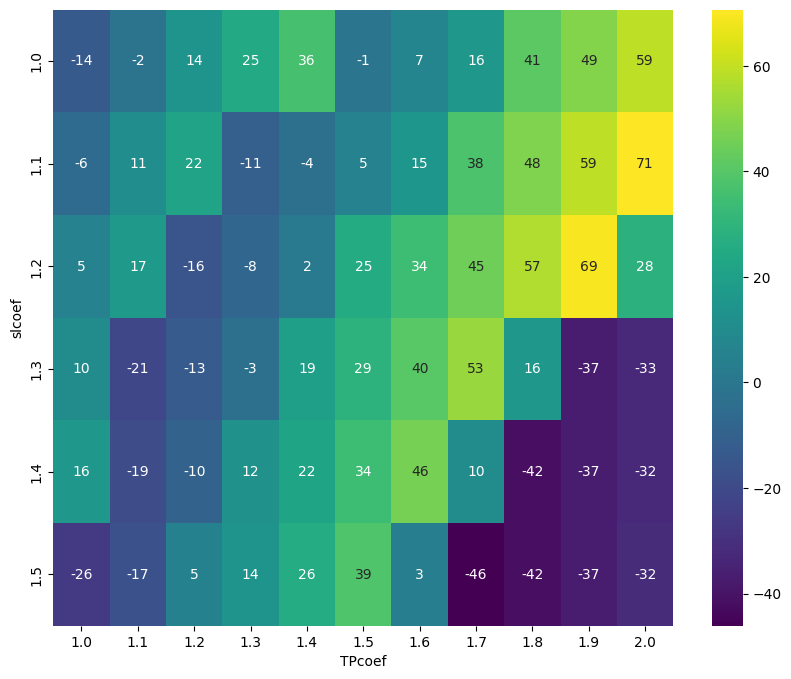

In [12]:
import seaborn as sns

for name, result_list in results.items():
    print("=== heatmap of {} ===".format(name))
    heatmap_df = result_list[1].unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
    plt.show()

In [13]:
# Add position points
for df in report_dict.values():
    df = add_pointpos_column(df, "Signal", 1e-4)


In [14]:
st=0
for name, df in report_dict.items():
    dfpl = df[st:st+320]

    # Create a plot with 2 rows
    fig = make_subplots(rows=2, cols=1, column_titles=[name])

    # Add candlestick plot on the first row
    fig.add_trace(go.Candlestick(x=dfpl.index,
                                open=dfpl['Open'],
                                high=dfpl['High'],
                                low=dfpl['Low'],
                                close=dfpl['Close']),
                row=1, col=1)

    # Add Bollinger Bands, EMA lines on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_low'],
                            line=dict(color='green', width=1),
                            name="BB_Low"),
                row=1, col=1)
    
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_mid'],
                            line=dict(color='yellow', width=1),
                            name="BB_MID"),
                row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_up'],
                            line=dict(color='green', width=1),
                            name="BB_UPPER"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                            marker=dict(size=8, color="MediumPurple"),
                            name="entry"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['rsi'], 
                            line=dict(color='brown', width=2),
                            name="RSI"),
                row=2, col=1)

    fig.update_layout(width=800, height=600, sliders=[])
    fig.show()
